In [117]:
import xarray as xr
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import rioxarray
from pathlib import Path
import pyproj
import scipy
from scipy.signal import savgol_filter
from dask.distributed import Client
import dask
import rasterio as rio
import numpy as np

In [2]:
client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52871,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:52880,Total threads: 2
Dashboard: http://127.0.0.1:52885/status,Memory: 10.67 GiB
Nanny: tcp://127.0.0.1:52876,


---

For testing:

In [74]:
ds = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={
        "lat": 25,
        "lon": 25,
        "time": -1,
    },  # this tells xarray to open the dataset as a dask array
)
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [ ]:
ds.air.chunks

---

In [70]:
testfile = Path("/Volumes/FIREICE/fihyper/cwaigl/20200830_BC/02_intermediate/brefcor/20200830-BC_03_VNIR_SWIR_rad_geo_atm_bcor_crop.bsq")
testdata_forcrs = rioxarray.open_rasterio(testfile, chunks=(-1, 256, 256), default_name="reflectance", variable='reflectance')

In [99]:
testdata = xr.open_dataset(testfile, engine="rasterio", chunks={'band': 1, 'x': 200, 'y': 400})

In [100]:
testdata

<xarray.Dataset>
Dimensions:      (band: 459, x: 1226, y: 8506)
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.354e+05 4.354e+05 ... 4.366e+05 4.366e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 400, 200), meta=np.ndarray>

In [101]:
testdata.attrs['long_name'] = "spectral reflectance, %*100"
testdata.attrs['name'] = "spectral reflectance, %*100"
testdata['band_data'].attrs['long_name']  =  "spectral reflectance, %*100"

In [102]:
testdata_forcrs.attrs['coordinate_system_string']

'PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-147.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'

In [103]:
testdata.band_data

<xarray.DataArray 'band_data' (band: 459, y: 8506, x: 1226)>
dask.array<open_dataset-b399baafdb2560f0f04eac805b1a753aband_data, shape=(459, 8506, 1226), dtype=float32, chunksize=(1, 400, 200), chunktype=numpy.ndarray>
Coordinates:
    fwhm         (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    wavelength   (band) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 453 454 455 456 457 458 459
  * x            (x) float64 4.354e+05 4.354e+05 ... 4.366e+05 4.366e+05
  * y            (y) float64 7.183e+06 7.183e+06 ... 7.175e+06 7.175e+06
    spatial_ref  int64 ...
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        886
    STATISTICS_MEAN:           39.097554278956
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         55.649407353098
    STATISTICS_VALID_PERCENT:  83.05
    wavelength:                410.36
    wavelength_units:          nm
    long_name:                 spectral reflectance, %*100
    acquisition_time:          2020-08-30T23:08:24.0Z
    bands:                     459
    band_names:                band   1, band   2, band   3, band   4, band  ...
    byte_order:                0
    coordinate_system_string:  PROJCS["WGS_1984_UTM_Zone_6N",GEOGCS["GCS_WGS_...
    data_ignore_value:         14000
    data_type:                 2
    default_bands:             291.000000, 141.000000, 20.000000
    file_type:                 ENVI Standard
    header_offset:             0
    interleave:                bsq
    lines:                     8506
    map_info:                  UTM, 1, 1, 435424.5, 7183053.5, 1, 1, 6, North...
    reflectance_scale_factor:  10000
    samples:                   1226
    sun_azimuth:               202.02
    sun_elevation:             31.880000000000003
    z_plot_range:              0, 10000
    z_plot_titles:              wavelength [nm], reflectance [%*100]

In [112]:
testdata.band_data[1, 1, 1].values

array(nan, dtype=float32)

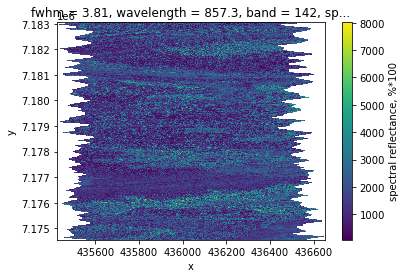

In [104]:
testdata.band_data.sel(band=142).plot()

In [113]:
selectionarray = testdata.band_data.sel(band=1).to_masked_array(copy=False)

In [123]:
selectionarray.shape

(8506, 1226)

In [124]:
weights = ~selectionarray.mask + 0 #Assign False = 0, True = 1
normalized = weights.ravel()/float(weights.sum())
    
index = np.random.choice(
    selectionarray.size, 
    size=100, 
    replace=False, 
    p=normalized
)        
idy, idx = np.unravel_index(index, selectionarray.shape)


In [125]:
testdata.x[idx]

<xarray.DataArray 'x' (x: 100)>
array([436420., 435501., 435581., 436087., 436129., 436053., 436369., 435764.,
       435575., 436304., 436031., 436377., 436033., 436042., 435752., 436282.,
       435984., 435931., 436523., 436479., 435971., 436190., 435872., 436320.,
       436242., 435717., 436282., 436013., 436085., 436225., 436279., 436204.,
       436522., 435722., 435741., 436385., 435902., 436479., 436031., 436196.,
       436193., 435780., 436322., 435817., 436364., 436539., 435577., 436051.,
       435770., 435695., 435852., 435871., 435922., 435484., 436155., 436252.,
       435571., 436319., 435649., 435943., 436115., 435962., 436190., 435518.,
       436055., 436388., 436341., 435621., 435760., 435701., 436097., 435594.,
       435659., 435561., 436071., 436171., 436012., 435726., 435984., 435579.,
       435710., 436228., 436517., 436325., 435861., 436280., 436402., 436465.,
       436381., 435583., 436138., 436066., 436474., 436007., 436371., 436507.,
       435562., 435756., 435865., 435939.])
Coordinates:
  * x            (x) float64 4.364e+05 4.355e+05 ... 4.359e+05 4.359e+05
    spatial_ref  int64 ...

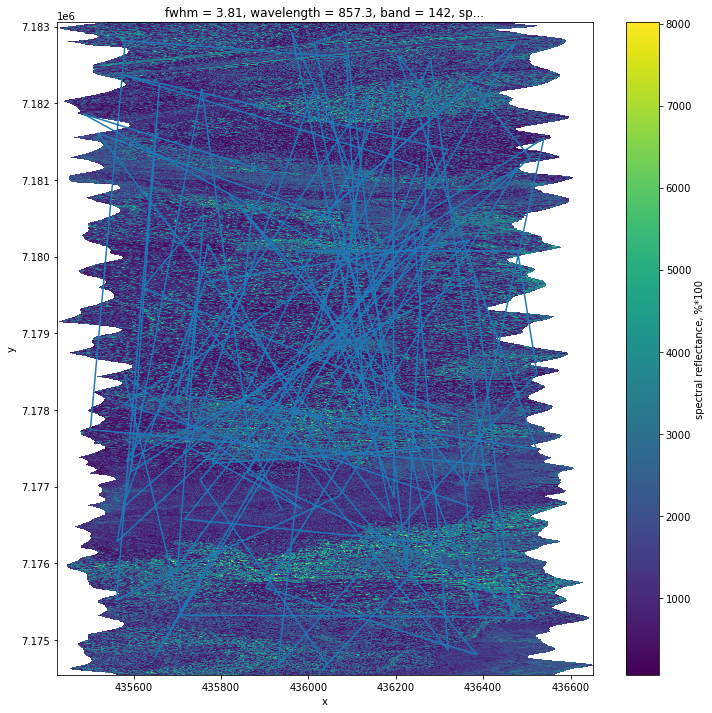

In [128]:
fig, ax = plt.subplots(figsize=(12, 12))
testdata.band_data.sel(band=142).plot(ax=ax)
ax.plot(testdata.x[idx], testdata.y[idy])

In [105]:
crs = pyproj.CRS.from_wkt(testdata_forcrs.attrs['coordinate_system_string'])
transformer = pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(4326), crs, always_xy=True) 
lonlat_to_crs = lambda lon, lat: transformer.transform(lon, lat)    

In [106]:
x, y = transformer.transform(-148.35, 64.7)

In [107]:
x, y

(435629.2061170959, 7175706.511372154)

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


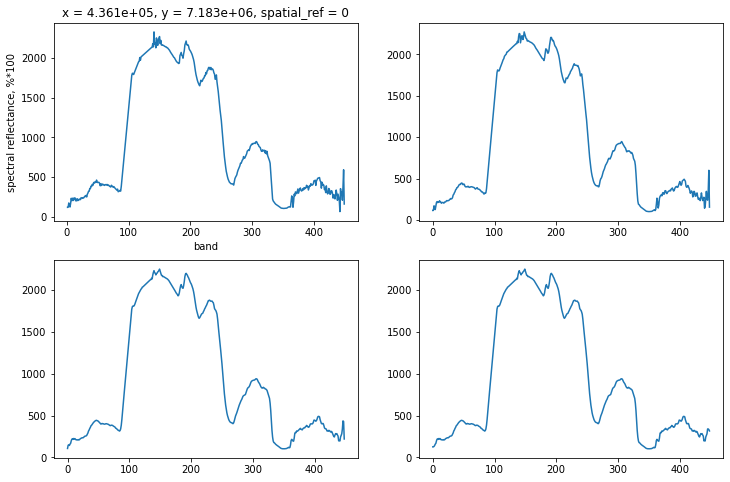

In [132]:
spec = testdata.band_data.sel(x=testdata.x[idx[3]], y=testdata.y[idy[3]], method='nearest')[:-10]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
print(ax)
spec.plot(ax=ax[0, 0])
ax[0, 1].plot(savgol_filter(spec.values, 7, 5))
ax[1, 0].plot(savgol_filter(spec.values, 7, 3))
ax[1, 1].plot(savgol_filter(spec.values, 7, 2))
#ax[1, 0].plot(wav_bin, spec_bin, )
#ax[1, 1].plot(wav_bin, savgol_filter(spec_bin, 9, 2))

working on spectrum #1
working on spectrum #2
working on spectrum #3
working on spectrum #4
working on spectrum #5
working on spectrum #6
working on spectrum #7
working on spectrum #8
working on spectrum #9
working on spectrum #10
working on spectrum #11
working on spectrum #12
working on spectrum #13
working on spectrum #14
working on spectrum #15
working on spectrum #16
working on spectrum #17
working on spectrum #18
working on spectrum #19
working on spectrum #20
working on spectrum #21
working on spectrum #22
working on spectrum #23
working on spectrum #24
working on spectrum #25
working on spectrum #26
working on spectrum #27
working on spectrum #28
working on spectrum #29
working on spectrum #30
working on spectrum #31
working on spectrum #32
working on spectrum #33
working on spectrum #34
working on spectrum #35
working on spectrum #36
working on spectrum #37
working on spectrum #38
working on spectrum #39
working on spectrum #40
working on spectrum #41
working on spectrum #42
w

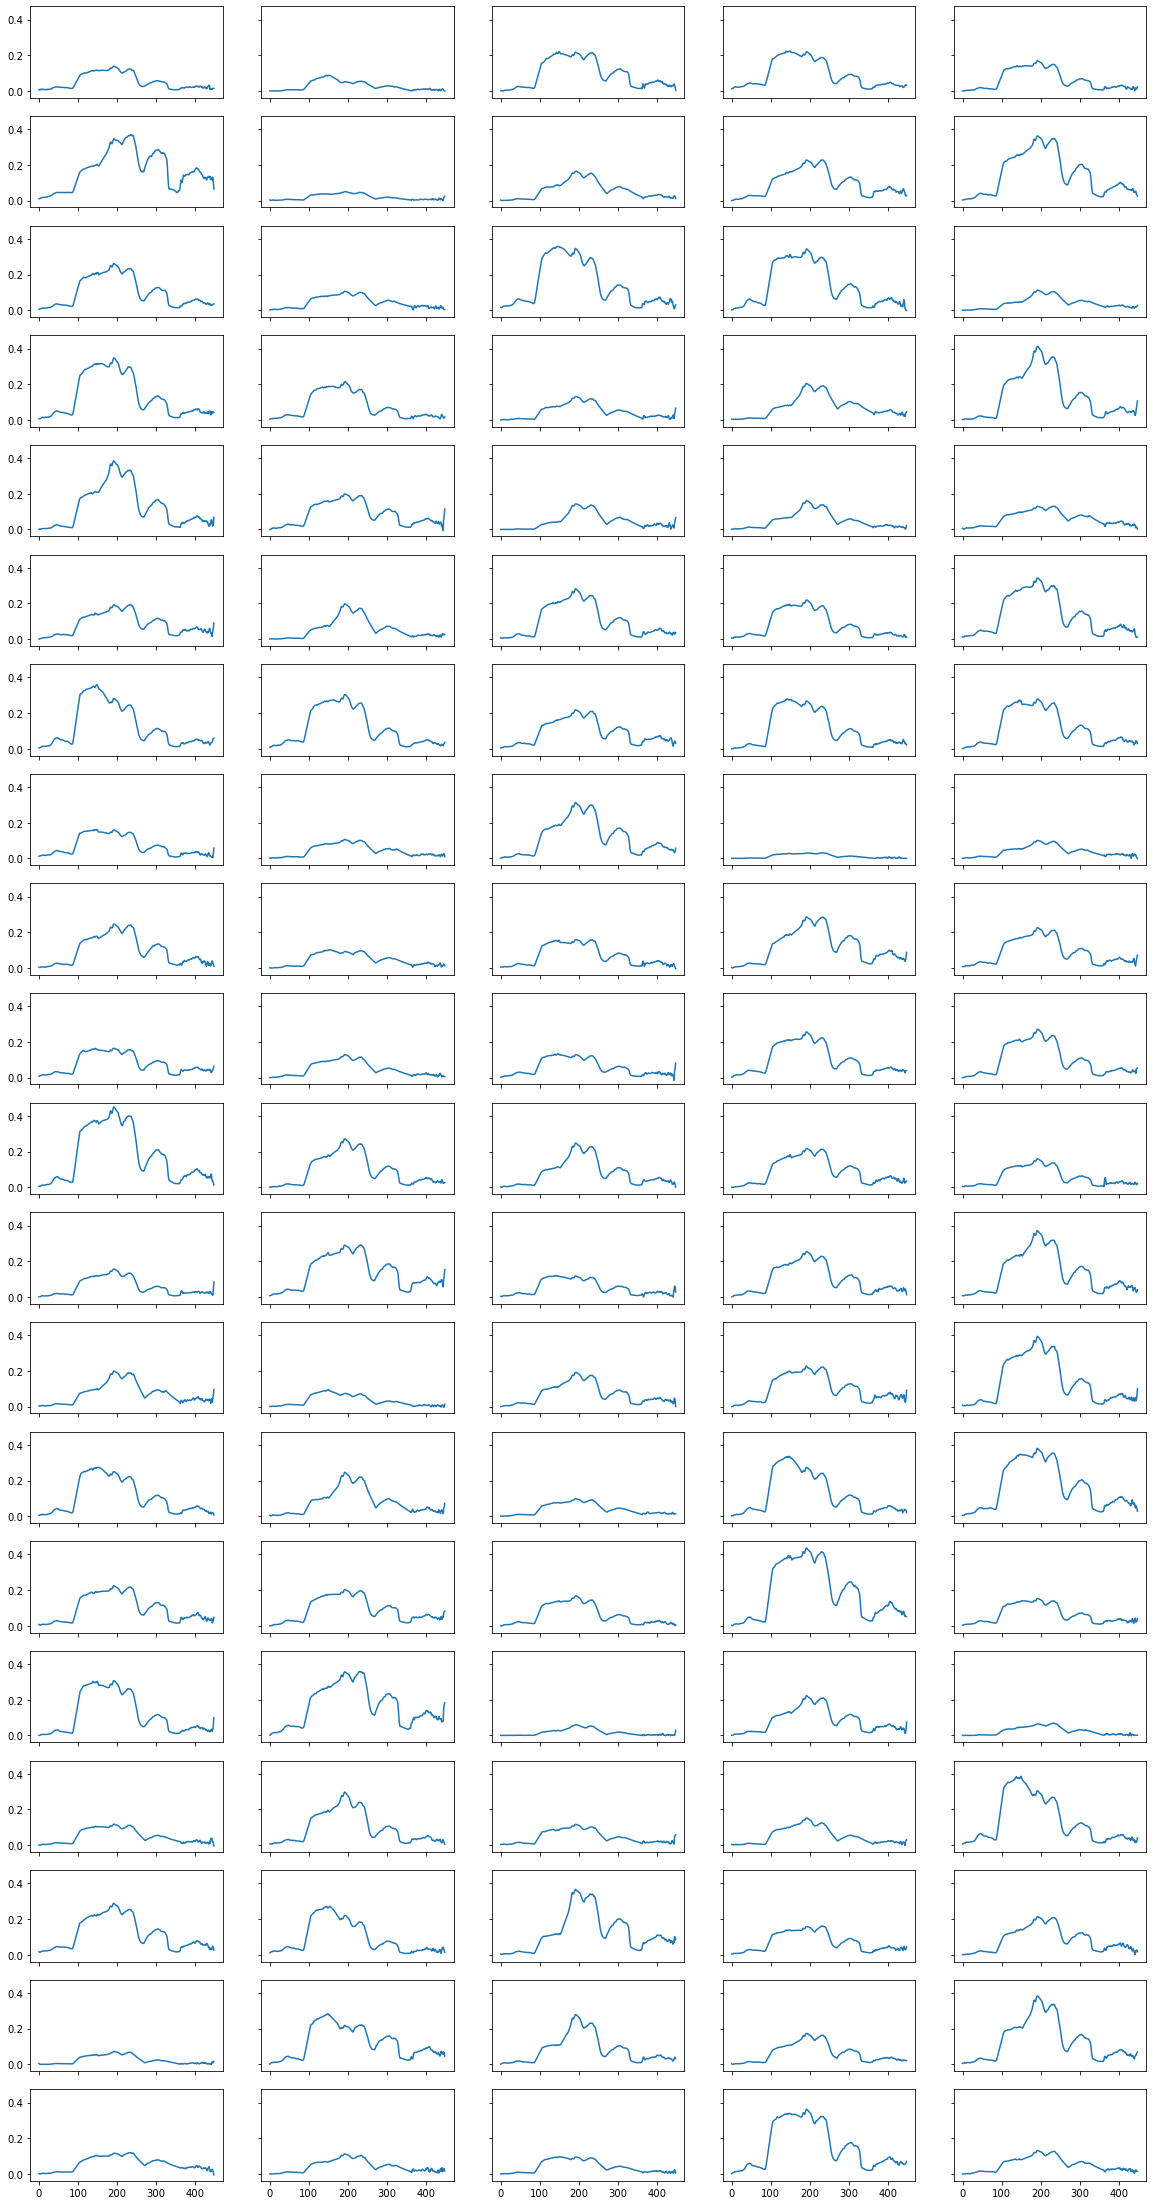

In [140]:
nmax = 20
mmax = 5

fig, axs = plt.subplots(nmax, mmax, figsize=(20, 40), sharex=True, sharey=True)
for ii, ax in enumerate(axs.flatten()):
        print(f"working on spectrum #{ii + 1}")
        spec = testdata.band_data.sel(x=testdata.x[idx[(ii)]], y=testdata.y[idy[ii]], method='nearest')[:-10]
#        spec.plot(ax=ax[ii, jj])
#ax[1, 0].plot(savgol_filter(spec.values, 7, 3))
        ax.plot(savgol_filter(spec.values, 7, 2)/10000)
#ax[1, 0].plot(wav_bin, spec_bin, )
#ax[1, 1].plot(wav_bin, savgol_filter(spec_bin, 9, 2))

In [142]:
testdata.x[idx]

<xarray.DataArray 'x' (x: 100)>
array([436420., 435501., 435581., 436087., 436129., 436053., 436369., 435764.,
       435575., 436304., 436031., 436377., 436033., 436042., 435752., 436282.,
       435984., 435931., 436523., 436479., 435971., 436190., 435872., 436320.,
       436242., 435717., 436282., 436013., 436085., 436225., 436279., 436204.,
       436522., 435722., 435741., 436385., 435902., 436479., 436031., 436196.,
       436193., 435780., 436322., 435817., 436364., 436539., 435577., 436051.,
       435770., 435695., 435852., 435871., 435922., 435484., 436155., 436252.,
       435571., 436319., 435649., 435943., 436115., 435962., 436190., 435518.,
       436055., 436388., 436341., 435621., 435760., 435701., 436097., 435594.,
       435659., 435561., 436071., 436171., 436012., 435726., 435984., 435579.,
       435710., 436228., 436517., 436325., 435861., 436280., 436402., 436465.,
       436381., 435583., 436138., 436066., 436474., 436007., 436371., 436507.,
       435562., 435756., 435865., 435939.])
Coordinates:
  * x            (x) float64 4.364e+05 4.355e+05 ... 4.359e+05 4.359e+05
    spatial_ref  int64 ...

In [160]:
testdata.x[idx[:5]].values

array([436420., 435501., 435581., 436087., 436129.])

In [163]:
xs = xr.DataArray(testdata.x[idx[:5]].values, dims="z")
ys = xr.DataArray(testdata.y[idy[:5]].values, dims="z")

sample = testdata.band_data.sel(x=xs, y=ys)
sample_df = sample.to_dataframe()
sample_df.drop(columns=['fwhm', 'wavelength', 'spatial_ref'], inplace=True)
sample_df.reset_index(inplace=True)
sample_df.pivot(index=['x', 'y'], columns='band', values='band_data')

,band,1,2,3,4,5,6,7,8,9,10,...,450,451,452,453,454,455,456,457,458,459
x,y,,,,,,,,,,,,,,,,,,,,,
435501.0,7177744.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1.0,0.0,...,0.0,0.0,0.0,186.0,1.0,3203.0,4.0,1577.0,4792.0,4.0
435581.0,7182818.0,0.0,42.0,0.0,0.0,0.0,0.0,1.0,30.0,0.0,18.0,...,0.0,184.0,0.0,0.0,745.0,81.0,2567.0,8324.0,2.0,3.0
436087.0,7182600.0,116.0,117.0,171.0,155.0,120.0,166.0,230.0,201.0,231.0,202.0,...,390.0,417.0,424.0,496.0,1672.0,1213.0,1481.0,614.0,2071.0,5383.0
436129.0,7177822.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26.0,38.0,20.0,...,241.0,213.0,381.0,1073.0,3042.0,1159.0,5226.0,1.0,852.0,1625.0
436420.0,7177279.0,56.0,86.0,66.0,26.0,30.0,139.0,91.0,103.0,79.0,63.0,...,216.0,507.0,1.0,982.0,3740.0,372.0,2314.0,1055.0,2299.0,14985.0


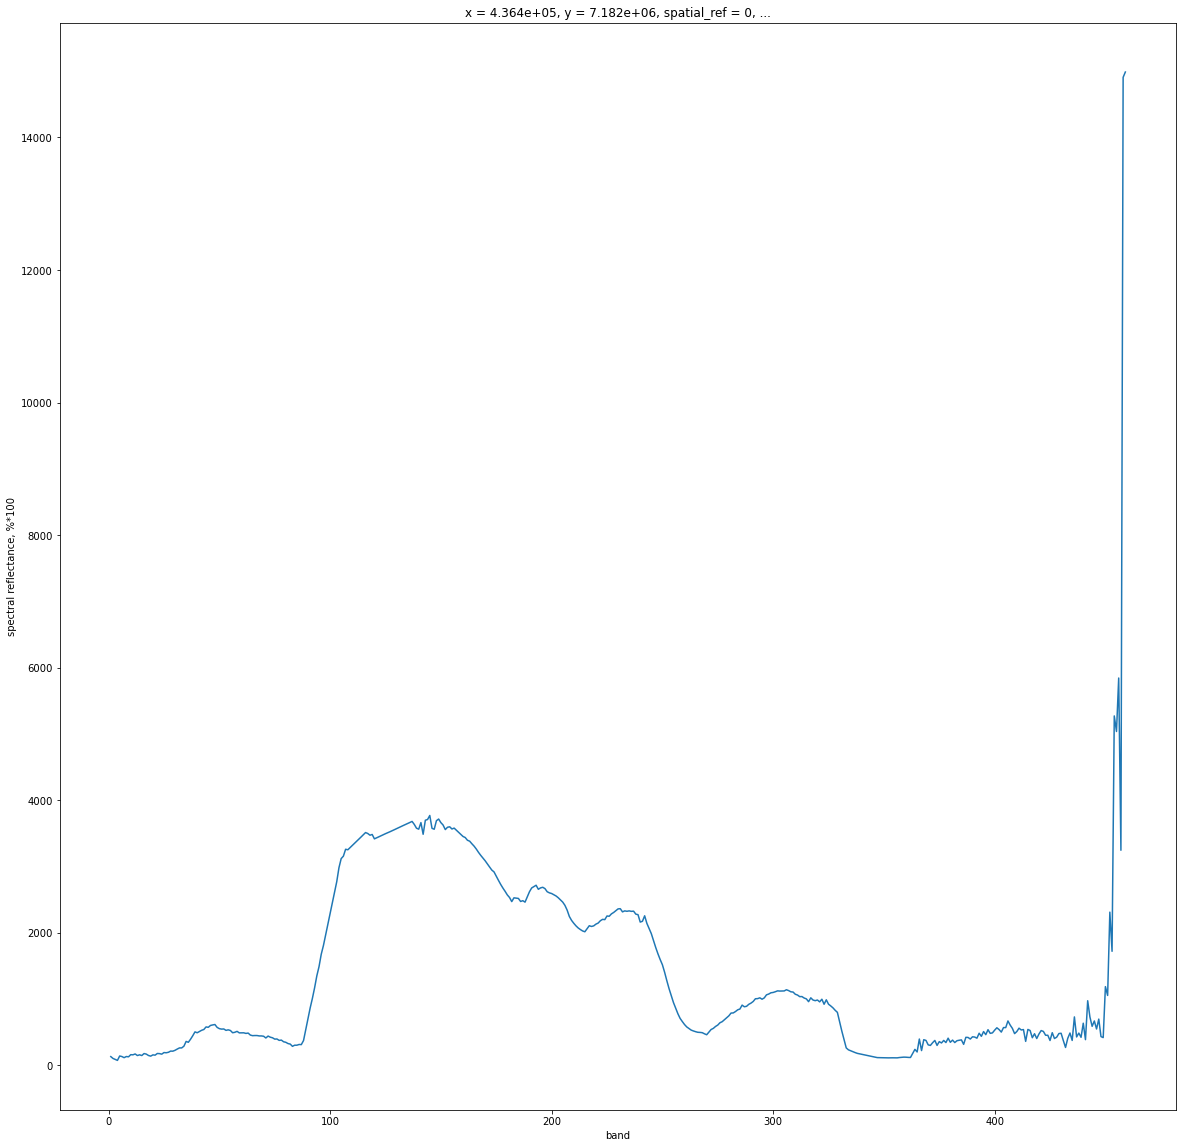

In [117]:
testdata.isel(x=1000, y=1000).plot(size=20, aspect=1)

In [169]:
testdata.sel(band=1).shape

(8506, 1226)

In [ ]:
da = xr.DataArray(
[[1,2,3],
       [4,5,6]],
dims=("x", "y"),
coords={"x": [0.5,1.5], "y": [2.5,1.5,0.5]},
)

d = {'geometry': [Polygon([(0, 0), (0,2), (2, 2), (2, 0)]),Polygon([(2,0),(2,2),(3,2),(3,0)])]}
gdf = gpd.GeoDataFrame(d)

zonal_stats(
    vectors=gdf,
    raster=da.values,
    affine=da.rio.transform(),
    stats=["mean","count"],
    all_touched=True,
)


/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/Users/christine/miniconda3/envs/python38_geo/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'mean': 4.5, 'count': 2}, {'mean': 6.0, 'count': 1}]

(0.0, 4.0)

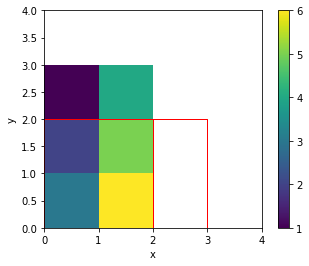

In [ ]:
#plotting to illustrate the data
fig, ax = plt.subplots()
da.plot(ax=ax,x="x",y="y")
gdf.boundary.plot(ax=ax, color='r', lw=1)
ax.set_xlim(0,4)
ax.set_ylim(0,4)

In [11]:
da.rio.transform()

Affine(1.0, 0.0, 0.0,
       0.0, -1.0, 3.0)